In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')
pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


No projector specified for this dataset. Please consider the method self.add_proj.


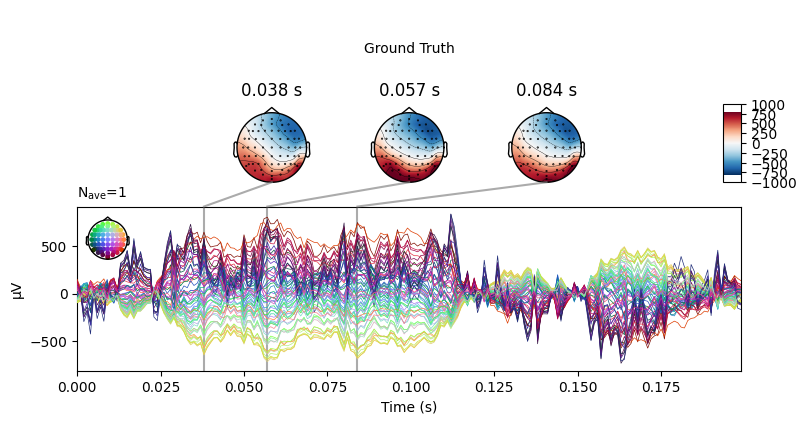

In [32]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=4,
    n_orders=(0,0),
    snr_range=(200, 300),
    n_timecourses=200,
    n_timepoints=200,
    scale_data=False)

gen = generator(fwd, **sim_params)

x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)
                        
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# Algo

In [36]:
import numpy as np

def alternating_projections(Y, n_dipoles, L, n="auto", max_iters=1000, mode="AP", stop_crit=0.975):
    S_AP=[]
    C = Y @ Y.T

    if n == "auto":
        u, D, _ = np.linalg.svd(C)
        D_ = D/D.max()
        n = np.where( abs(np.diff(D_)) < 0.001 )[0]
        n = n[0]
        print(n)

    u, _, _ = np.linalg.svd(C, full_matrices=False)
    C = u[:,:n] @ u[:,:n].T
    
    # if mode == 'AP':
    #     C += 1e-3 * np.trace(C * np.identity(Y.shape[0]))
    # elif mode == 'AP-w-MUSIC':
    #     u,s,_=np.linalg.svd(C)
    #     C = u[:, :n] @ np.diag(s[:n]) @ u[:, :n].T
    # elif mode == 'AP-MUSIC':
    #     u, _, _ = np.linalg.svd(C)
    #     C = u[:,:n] @ u[:,:n].T

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # % 1st Phase
    # % a) Initialization: search the 1st source location over the entire
    # % dipoles topographies space (ndipoles=15,002 topographies)
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    ap_val1 = np.diag(L.T @ C @ L) / np.diag(L.T @ L)
    s1_idx = np.argmax(ap_val1)
    print(f"adding first candidate. Value: {ap_val1.max()} at idx {s1_idx}")
    S_AP.append( s1_idx )

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # % (b) Now, add one source at a time
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    for q in range(1,n):
        A = L[:, S_AP]
        P_A = A @ np.linalg.pinv(A.T @ A) @ A.T
        Q = np.identity(P_A.shape[0]) - P_A
        ap_val2 = np.diag(L.T @ Q @ C @ Q @ L) / np.diag(L.T @ Q @ L)
        if ap_val2.max() < stop_crit:
            break
        s2_idx = np.argmax(ap_val2)
        S_AP.append( s2_idx )
        print(f"adding new value {ap_val2.max()} at idx {s2_idx}")

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # % 2nd Phase
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    S_AP_2 = S_AP
    for iter in range(max_iters):
        S_AP_2_Prev = S_AP_2
        for q in range(n):
            S_AP_TMP = S_AP_2.copy()
            S_AP_TMP.pop(q)
            A = L[:, S_AP_TMP]
            P_A = A @ np.linalg.pinv(A.T @ A) @ A.T
            Q = np.identity(P_A.shape[0]) - P_A
            ap_val2 = np.diag(L.T @ Q @ C @ Q @ L) / np.diag(L.T @ Q @ L)
            sq_idx = np.argmax(ap_val2)
            S_AP_2[q] = sq_idx
            print(f"refinement: adding new value {ap_val2.max()} at idx {sq_idx}")
            
        if iter > 0 and S_AP_2 == S_AP_2_Prev:
            break
    return S_AP, S_AP_2


## Plot

In [37]:
from scipy.sparse import csr_matrix
n_chans, n_dipoles = leadfield.shape
Y = evoked.data

Y -= Y.mean(axis=0)
Y /= abs(Y).mean()
leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

max_iters = 1000
mode = "AP-MUSIC"
n = "auto"
S_AP, S_AP_2 = alternating_projections(Y, n_dipoles, leadfield, n, max_iters, mode)

idc = np.array(S_AP)
n_chans, n_times = Y.shape
n_dipoles = leadfield.shape[1]
X = np.zeros((n_dipoles, n_times))
source_covariance = np.zeros(n_dipoles)
source_covariance[idc] = 1

source_covariance = csr_matrix(np.diag(source_covariance))
L_s = leadfield @ source_covariance
L = leadfield
W = np.diag(np.linalg.norm(L, axis=0)) 
# print(source_covariance.shape, L.shape, W.shape)
inverse_operator = source_covariance @ np.linalg.inv(L_s.T @ L_s + W.T @ W) @ L_s.T
X = inverse_operator @ Y

stc_ = stc.copy()
stc_.data = X
stc_.plot(**pp)

3
adding first candidate. Value: 0.999999361537211 at idx 1256
adding new value 0.9999876233443465 at idx 284
adding new value 0.9999702702694103 at idx 414
refinement: adding new value 0.9999920005225771 at idx 1256
refinement: adding new value 0.9999866334665415 at idx 284
refinement: adding new value 0.9999702702694103 at idx 414
refinement: adding new value 0.9999920005225771 at idx 1256
refinement: adding new value 0.9999866334665415 at idx 284
refinement: adding new value 0.9999702702694103 at idx 414


Using control points [0.         0.         0.86125737]


# Algo old

In [9]:
import numpy as np

def alternating_projections(Y, n_dipoles, L, n="auto", max_iters=1000, mode="AP"):
    S_AP=[]
    if n == "auto":
        u, D, _ = np.linalg.svd(np.dot(Y,Y.T))
        D_ = D/D.max()
        n = np.where( abs(np.diff(D_)) < 0.001 )[0]
        n = n[0]
        print(n)
    if mode == 'AP':
        C=np.dot(Y,Y.T)+(1e-3)*np.trace(np.dot(Y,Y.T))*np.eye(Y.shape[0])
    elif mode == 'AP-w-MUSIC':
        u,s,_=np.linalg.svd(np.dot(Y,Y.T))
        C=np.dot(np.dot(u[:,:n],np.diag(s[:n])),u[:,:n].T)
    elif mode == 'AP-MUSIC':
        u, _, _ = np.linalg.svd(np.dot(Y,Y.T))
        
        C=np.dot(u[:,:n],u[:,:n].T)

    

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # % 1st Phase
    # % a) Initialization: search the 1st source location over the entire
    # % dipoles topographies space (ndipoles=15,002 topographies)
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # ap_val1=np.zeros(n_dipoles)
    # for p in range(n_dipoles):
    #     l_p=L[:,p]
    #     ap_val1[p]=np.dot(np.dot(l_p.T,C),l_p)/np.dot(l_p.T,l_p)

    ap_val1 = np.diag(L.T @ C @ L) / np.diag(L.T @ L)
    print(ap_val1)
    s1_idx=np.argmax(ap_val1)
    S_AP.append(s1_idx)

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # % (b) Now, add one source at a time
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    for q in range(1,n):
        ap_val2=np.zeros(n_dipoles)
        A=L[:,S_AP]
        P_A=np.dot(np.dot(A,np.linalg.pinv(np.dot(A.T,A))),A.T)
        Q=np.eye(P_A.shape[0])-P_A
        for p in range(n_dipoles):
            l_p=L[:,p]
            ap_val2[p]=np.dot(np.dot(np.dot(l_p.T,Q),C),np.dot(Q,l_p))/np.dot(np.dot(l_p.T,Q),l_p)
        s2_idx=np.argmax(ap_val2)
        S_AP.append(s2_idx)

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # % 2nd Phase
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    S_AP_2 = S_AP
    for iter in range(max_iters):
        S_AP_2_Prev = S_AP_2
        for q in range(n):
            ap_val2=np.zeros(n_dipoles)
            S_AP_TMP = S_AP_2.copy()
            S_AP_TMP.pop(q)
            A=L[:,S_AP_TMP]
            P_A=np.dot(np.dot(A,np.linalg.pinv(np.dot(A.T,A))),A.T)
            Q=np.eye(P_A.shape[0])-P_A
            for p in range(n_dipoles):
                l_p=L[:,p]
                ap_val2[p]=np.dot(np.dot(np.dot(l_p.T,Q),C),np.dot(Q,l_p))/np.dot(np.dot(l_p.T,Q),l_p)
            sq_idx=np.argmax(ap_val2)
            S_AP_2[q]=sq_idx
        if iter>0 and S_AP_2 == S_AP_2_Prev:
            break
    return S_AP,S_AP_2
